# Проект для "Викишоп"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В ходе нашего проекта мы создадим модель, которая позволит классифицировать комментарии на токсичные и положительные. Критерием качества для нашего проекта будет являться метрика F1. Постараемся добиться того, чтобы значение этой метрики было не меньше 0.75.

Исходные данные будут представлять из себя датафрейм текстовых комментариев - с полем text и оценкой их токсичностей в поле toxic. Для обучения воспользуемся несколькими моделями машинного обучения и выберем наилучшую, учитывая как качество, так и скорость предсказания. 

Основные этапы работы над проектом
- загрузка и предобработка исходных данных - выявление аномалий, пропусков и других особенностей в данных. 
- подготовка данных для обучения. 
- обучение на разных моделях машинного обучения. 
- тестирование, проверка на даеватность и формулировка выводов. 

In [33]:
#импортируем все используемые в проекте модули 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy.random import RandomState
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer 
import nltk
from nltk.corpus import stopwords as nltk_stopwords
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

# 1. Предобработка данных.

Проведем предобработку исходных данных. Изучим возможные пропуски, дубликаты, проанализируем количество токсичных и нетоксичных комментариев.

In [2]:
#Проведем считывание данных в датафрейм data
try:
    data= pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('toxic_comments.csv')

In [3]:
#Выведем на экран первые 10 строчек датафрейма
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [4]:
#Выведем общую информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
#Посмотрим на количество дубликатов 
print(data.duplicated().sum())

0


**Вывод**: в ходе первых шагов предварительной обработки не обнаружено дубликатов, пропущеных значений, а также несоответсвия типов данных. 

Проанализируем количество токсичных и нетоксичных комментариев. 

Text(0, 0.5, 'Количество')

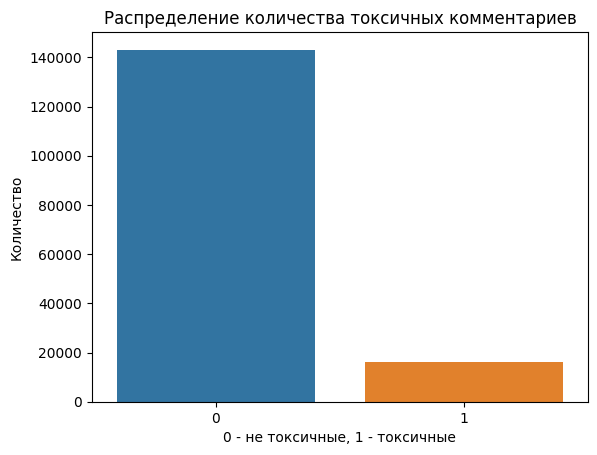

In [6]:
sns.countplot(x=data["toxic"])
plt.title('Распределение количества токсичных комментариев')
plt.xlabel ('0 - не токсичные, 1 - токсичные')
plt.ylabel('Количество')

In [7]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

**Вывод**: Количество нетоксичных комментариев практически в 9 раз больше, чем количество токсичных. В контексте моделей обучения для задачи классификации можно утверждать, что представленных классы несбалансированные, и при построении различных моделей это необходимо учитывать. 

**Общий вывод**: Таким образом в ходе предообработки данных мы не обнаружили дубликатов или пропущенных значений, но выявили, что количество токсичных комментариев практически в 9 раз меньше, чем  нетоксичных.

# 2. Подготовка модели

Поскольку мы работаем с текстовыми данными для формирования признаков в модели машинного обучения необходимо провести лемматизацию и векторизацию данных. Дальнейшая подготовка будет состоять из разделения выборки на обучающую и тестовую.

In [8]:
#Проведем лемматизацию данных с помощью WordNetLemmatizer
m = WordNetLemmatizer()
nltk.download('wordnet')
def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(m.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diguz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
#Применим функцию лемматизации к исходным данным
data['text_lemmatized'] = data['text'].apply(lemmatize_text)

In [10]:
data.head()

,Unnamed: 0,text,toxic,text_lemmatized
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [11]:
data = data.drop(['text'], axis = 1)
data.head()

,Unnamed: 0,toxic,text_lemmatized
0,0,0,explanation why the edits made under my userna...
1,1,0,d aww he matches this background colour i m se...
2,2,0,hey man i m really not trying to edit war it s...
3,3,0,more i can t make any real suggestions on impr...
4,4,0,you sir are my hero any chance you remember wh...


In [12]:
#Выделим обучающие признаки и целевой
target = data['toxic']
features = data.drop(['toxic'], axis=1)

Проведем теперь разделение нашей исходной выборки на обучающую и тестовую в соотношении 3:1.

In [13]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=1234, stratify = data['toxic'])

Проведем теперь векторизацию данных с помощью TF-IDF. 

In [14]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diguz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
features_train = count_tf_idf.fit_transform(features_train['text_lemmatized'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['text_lemmatized'].values.astype('U'))

**Вывод**: были сформированы признаки для выборки, исходные данные были разделены на обучающую и тестовые выборки.

# 3. Обучение моделей

## 3.1 Логистическая регрессия 

Учтем несбалансированность классов для логистической регрессии и проведем кросс-валидацию с использованием метрики F1.

In [16]:
model_lr = LogisticRegression(class_weight='balanced')

In [26]:
grid = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10]
        }]

gsearch = GridSearchCV(estimator=model_lr, 
                       cv=2, 
                       param_grid=grid,  
                       scoring = 'f1')
import warnings
warnings.filterwarnings('ignore')
gsearch.fit(features_train, target_train)

GridSearchCV(cv=2, estimator=LogisticRegression(class_weight='balanced'),
             param_grid=[{'C': [0.1, 1, 10],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear']}],
             scoring='f1')

In [27]:
gsearch.best_score_

0.7616539894981854

## 3.2 CatBoostClassifier

In [22]:
model_cb = CatBoostClassifier(verbose=False)

In [24]:
grid = [{'iterations':[200, 300, 400]
        }]

gsearch_2 = GridSearchCV(estimator=model_cb, 
                       cv=2, 
                       param_grid=grid,  
                       scoring = 'f1')

gsearch_2.fit(features_train, target_train)

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000012909A1C2B0>,
             param_grid=[{'iterations': [200, 300, 400]}], scoring='f1')

In [25]:
gsearch_2.best_score_

0.7226697881313073

**Вывод**: Таким образом, сравнив две модели по параметру F1, мы получаем, что наиболее подходящая - модель логистической регрессии.

# 4. Тестирование 

Проведем тестирование лучшей модели.

In [31]:
predictions = gsearch.best_estimator_.predict(features_test)

In [32]:
f1_score(predictions, target_test)

0.7685367264314633

Проведем проверку модели на адекватность.

In [46]:
dummy_clf = DummyClassifier(strategy="constant", constant = 0)

In [48]:
dummy_clf.fit(features_train, target_train)
predictions_dm = dummy_clf.predict(features_test)
f1_score(predictions_dm, target_test)

0.0

**Вывод**: подобранная модель соответствует требованием и выдает на тестовой выборке значение метрики **F1 = 0.77.**

# Вывод.

В ходе работы над проектом были проанализированы исходные данные и выявленна особенность несбалансированности исходных классов. Далее данные были подготовлены для формирования модели обучения - проведена их лемматизация и векторизация. Данные были также разделены на две выборки - обучающую и тестовую. 

В качестве моделей были выбраны - логистическая регрессия и CatBoostClassifier (градиентный бустинг). На кросс-валидации наилучший результат был получен у логистической регресии, поэтому в конечном итоге выбрана именно она. 

Было также проведено тестирование выбранной модели и определена метрика F1, которая составила **0.77**, что удовлетворяет поставленной выше задаче. 